# TME sur la classification de lettres manuscrites
## Format des données
Nous travaillerons sur des lettres manuscrites.
Les données sont fournies au format pickle (le standard de sérialisation python, particulièrement convivial). Pour les charger : 

In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

with open('ressources/lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées 

<ipython-input-1-02313c2afce2>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(data.get('letters')) # récupération des données sur les lettres


Les données sont dans un format original: une lettre est en fait une série d'angles (exprimés en degrés). Un exemple: 

In [2]:
X[0]

array([ 36.214493, 347.719116, 322.088898, 312.230957, 314.851013,
       315.487213, 313.556702, 326.534973, 141.288971, 167.606689,
       199.321594, 217.911087, 226.443298, 235.002472, 252.354492,
       270.045654, 291.665161, 350.934723,  17.892815,  20.281025,
        28.207161,  43.883423,  53.459026])

Lors de l'acquisition, un stylo intelligent a pris des mesures régulièrement dans le temps: chaque période correspond à un segment de droite et le stylo a calculé l'angle entre deux segments consécutifs... C'est l'information qui vous est fournie.

Pour afficher une lettre, il faut reconstruire la trajectoire enregistrée... C'est ce que fait la méthode ci-dessous: 

In [3]:
# affichage d'une lettre
def tracerLettre(let):
    a = -let*np.pi/180; # conversion en rad
    coord = np.array([[0, 0]]); # point initial
    for i in range(len(a)):
        x = np.array([[1, 0]]);
        rot = np.array([[np.cos(a[i]), -np.sin(a[i])],[ np.sin(a[i]),np.cos(a[i])]])
        xr = x.dot(rot) # application de la rotation
        coord = np.vstack((coord,xr+coord[-1,:]))
    plt.figure()
    plt.plot(coord[:,0],coord[:,1])
    #plt.savefig("exlettre.png")
    return

a


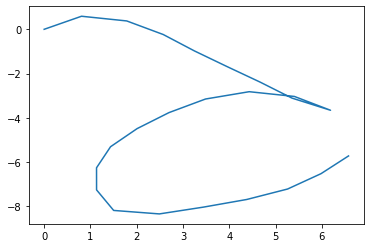

In [4]:
# il s'agit d'un 'a'
tracerLettre(X[0])
print(Y[0]) # vérification de l'étiquette

## A. Apprentissage d'un modèle CM (max de vraisemblance)
### A1. Discrétisation

**1 état = 1 angle**

Il est nécessaire de regrouper les angles en un nombre fini d'états (par exemple 20)
- définir un `intervalle = 360 / n_etats` (18° si on choisit 20 états)
- discrétiser tous les signaux à l'aide de la formule `np.floor(x / intervalle)`
    - si n_etats = 20 alors [0, 18[ => 0, [18, 36[ => 1, etc...

Donner le code de la méthode `discretise(x, d)` qui prend la base des signaux et retourne une base de signaux discrétisés.

In [5]:
def discretise(x, d):
    intervalle=360/d
    discretisation = np.copy(x)
    for i in range(len(x)):
        discretisation[i]=np.floor(x[i]/intervalle)
    
    return discretisation
    
    # Votre code :
    


In [6]:
print(discretise(X[0],3))

[0. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 0. 0. 0. 0. 0.]


**VALIDATION :** code du premier signal avec une discrétisation sur 3 états:
```python
array([ 0.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  1.,  1.,  1.,  1., 1., 1., 2., 2.,  2.,
       2.,  0.,  0.,  0.,  0.,  0.])
```

### A2. Regrouper les indices des signaux par classe (pour faciliter l'apprentissage)

In [7]:
def groupByLabel(y):
    index = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        index.append(ind)
    return index

Cette méthode produit simplement une structure type:
```python
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]),
 array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]),
 array([33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]),
 array([44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]),
 array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]),
 ...
```
Chaque ligne regroupe les indices de signaux correspondant à une classe. Il y a donc 11 exemples de 'a'.

### A3. Apprendre les modèles CM

Soit {$X_C$} la base de signaux discrétisés correspondant à une classe {$C$} et {$d$} le nombre d'états. Donner le code de la fonction `learnMarkovModel(Xc, d)` qui retourne un tuple contenant Pi et A.

Rappel:
- Initialisation de 
```python
 A = np.zeros((d, d))
 Pi = np.zeros(d)```
- Parcours de tous les signaux et incréments de A et Pi
- Normalisation (un peu réfléchie pour éviter les divisions par 0)
```python
A = A / np.maximum(A.sum(1).reshape(d, 1), 1) # normalisation
Pi = Pi / Pi.sum()```

**Note** : la solution proposée pour gérer le cas des lignes entièrement à 0 est naïve et n'est pas totalement satisfaisante. Comprendre pourquoi. On proposera une solution améliorée plus loin dans le TME. 

In [8]:
def learnMarkovModel(Xc, d):
    A = np.zeros((d, d))
    Pi = np.zeros(d)
    for j in range(len(Xc)): #on parcourt ex par ex
        a = Xc[j] # valeurs pour 1 ex de la lettre
        etat = int(a[0])
        Pi[etat] += 1
        for x in range(len(a)-1): #on parcourt les données de chaque ex de la lettre
            a_i = int(a[x])
            a_j = int(a[x + 1])
            A[a_i][a_j] += 1
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1) #normalisation
    Pi = Pi / Pi.sum()
    
    return Pi, A

In [9]:
d=3
index=groupByLabel(Y)
lettre=X[index[0]]
Xc=discretise(lettre,d)
learnMarkovModel(Xc,d)

(array([0.36363636, 0.        , 0.63636364]),
 array([[0.84444444, 0.06666667, 0.08888889],
        [0.        , 0.83333333, 0.16666667],
        [0.11382114, 0.06504065, 0.82113821]]))

**Validation :** premier modèle avec une discrétisation sur 3 états :
```python
(array([ 0.36363636,  0.        ,  0.63636364]),
 array([[ 0.84444444,  0.06666667,  0.08888889],
       [ 0.        ,  0.83333333,  0.16666667],
       [ 0.11382114,  0.06504065,  0.82113821]]))
```

### A4. Stocker les modèles dans une liste

Pour un usage ultérieur plus facile, on utilise le code suivant :

In [10]:
d = 20                   # paramètre de discrétisation
Xd = discretise(X, d)    # application de la discrétisation
index = groupByLabel(Y)  # groupement des signaux par classe
models = []
for cl in range(len(np.unique(Y))): # parcours de toutes les classes et optimisation des modèles
    models.append(learnMarkovModel(Xd[index[cl]], d))

### A5. Distribution stationnaire

La distribution stationnaire $\mu$, pour un système ergodique, correspond à:

- la distribution des états observés dans l'ensemble des données
- la distribution obtenu après un grand nombre de passage dans $A$ à partir de n'importe quelle distribution ou état d'origine (une matrice de transition ergodique va nous permettre de converger)
- la solution de l'équation de stabilité: $\mu = \mu A$

Dans le cas de la lettre 'a' et d'une discrétisation en 3 états, calculer la distribution stationnaire par les deux première méthode et vérifier que vous obtenez des résultats similaires.

**Note:** pour la marche aléatoire, vous construirez une boucle sur 100 iérations (borne sup) et vous sortirez dès que la somme des écarts (en absolu) entre $\mu_t$ et $\mu_{t+1}$ est inférieure à $10^{-3}$. Vous vérifierez ensuite que le système converge quelque soit l'état de départ (3 appel àla fonction) ou avec une initialisation aléatoire.

In [11]:
import random
import copy
lettre=X[index[0]]
d=3
Xc=discretise(lettre,d)
A=learnMarkovModel(Xc,d)[1]


def methode1(Xc,d):
    mu1=np.zeros(d)
    for i in range(len(Xc)):
        for j in range(len(Xc[i])):
            mu1[int(Xc[i][j])]+=1
    mu1=mu1/mu1.sum()
    return mu1

def methode2(Xc,d,A):#uniquement pour 3 classes
    
    mu1=np.zeros(d)
    mu1[0]=random.random()
    mu1[1]=random.uniform(0,1-mu1.sum())#pour que aucune valeur ne depasse 1
    mu1[2]=1-mu1.sum()#pour que l'ensembe somme à 1
    i=0
    mu1t=np.zeros(d)
    while(np.sum(np.abs(mu1t-mu1))>(10**-3))and(i<100):
        mu1t=copy.deepcopy(mu1)
        mu1=np.dot(mu1,A)
        i+=1
    return mu1, mu1t


In [12]:
mu1=methode1(Xc,d)
mu2,mu2t=methode2(Xc,d,A)
print(mu1)
print(mu2)
print("difference entre mu1 et mu2=",np.sum(np.abs(mu1-mu2)))
print("difference entre mu2 et mu2t=",np.sum(np.abs(mu2t-mu2)))
#question à poser au prof 

[0.22857143 0.26938776 0.50204082]
[0.30441289 0.28229375 0.41329335]
difference entre mu1 et mu2= 0.17749492347381676
difference entre mu2 et mu2t= 0.0008015567109238564


##  B. Test (affectation dans les classes sur critère MV)
### B1. (log)Probabilité d'une séquence dans un modèle

Donner le code de la méthode `probaSequence(s,Pi,A)` qui retourne la log-probabilité d'une séquence `s` dans le modèle {$\lambda=\{Pi,A\}$} 

In [13]:
def probaSequence(s, Pi, A):
    logproba=Pi[int(s[0])]
    pos=int(s[0]) #position precedente
    for i in s[1:]:
        logproba=logproba*A[pos][int(i)]
        pos=int(i)
    if logproba!=0:
        logproba=np.log(logproba)
    else:
        logproba=-np.inf
    return logproba

In [14]:
s=discretise(X[0],3)#discretisation 1er signal sur 3 états
d=3
proba=[]
for i in range(26):
    model=X[index[i]]
    model_discret=discretise(model,d)
    Pi,A=learnMarkovModel(model_discret,d)
    p=probaSequence(s,Pi,A)
    proba.append(p)
proba=np.array(proba)
print(proba)

[-13.491086           -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
         -inf         -inf         -inf         -inf         -inf
 -12.48285678]


**VALIDATION :** probabilité du premier signal dans les 26 modèles avec une discrétisation sur 3 états :
```python
array([-13.491086  ,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf,         -inf,         -inf,         -inf,
               -inf, -12.48285678])
```

- Ce signal est-il bien classé ?
- D'où viennent tous les `-inf` ? 

Ce signal est bien classé pour la lettre a, en effet on obtient un score de -13.491086.

Cependant, le score du pour la lettre z est extrement proche aussi. C'est une erreur qui peut se comprendre quand on voit le dessin de la lettre a par rapport à la lettre z.

Les -inf viennent du fait qu'on a multiplie par 0 a un moment; que ce soit au debut avec Pi ou bien lors d'un passage dans la matrice de passage A. Or log(0) n'est pas possible donc on met -inf. 

### B2. Application de la méthode précédente pour tous les signaux et tous les modèles de lettres

L'application se fait en une ligne de code si vous avez respecté les spécifications précédentes : 

In [15]:
proba = np.array([[probaSequence(Xd[i], models[cl][0], models[cl][1]) for i in range(len(Xd))]
                  for cl in range(len(np.unique(Y)))])

### B3. Evaluation des performances

Pour l'évaluation, nous proposons l'approche suivante: 

In [16]:
# calcul d'une version numérique des Y :
Ynum = np.zeros(Y.shape)
for num, char in enumerate(np.unique(Y)):
    Ynum[Y == char] = num
    
# Calcul de la classe la plus probable :
pred = proba.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
np.where(pred != Ynum, 0.,1.).mean()

0.914179104477612

**INDICE DE PERFORMANCE :** 91% de bonne classification avec 20 états, 69% avec 3 états

## C. Biais d'évaluation, notion de sur-apprentissage

Dans le protocole précédent, nous avons triché:
- les données servent d'abord à apprendre les modèles...
- puis nous nous servons des mêmes données pour tester les modèles ! Les performances sont forcément bonnes ! 

Afin de palier le problème, nous allons diviser en deux la base de données: une partie servira à l'apprentissage des modèles, l'autre à leur évaluation. Pour effectuer la division, nous fournissons le code suivant: 

In [17]:
# separation app/test, pc=ratio de points en apprentissage
def separeTrainTest(y, pc):
    indTrain = []
    indTest = []
    for i in np.unique(y): # pour toutes les classes
        ind, = np.where(y == i)
        n = len(ind)
        indTrain.append(ind[np.random.permutation(n)][:int(np.floor(pc * n))])
        indTest.append(np.setdiff1d(ind, indTrain[-1]))
    return indTrain, indTest

# exemple d'utilisation
itrain, itest = separeTrainTest(Y, 0.8)

dans `itrain`, nous obtenons les indices des signaux qui doivent servir en apprentissage pour chaque classe :

In [18]:
itrain

[array([8, 2, 0, 1, 7, 4, 6, 5], dtype=int64),
 array([16, 17, 18, 21, 15, 12, 14, 11], dtype=int64),
 array([27, 22, 31, 30, 24, 28, 26, 23], dtype=int64),
 array([36, 41, 34, 42, 33, 39, 43, 35], dtype=int64),
 array([49, 45, 47, 46, 54, 44, 51, 53], dtype=int64),
 array([58, 62, 59, 65, 64, 61, 60, 55], dtype=int64),
 array([70, 73, 74, 69, 71, 75, 68, 72], dtype=int64),
 array([77, 82, 83, 84, 86, 85, 87, 80], dtype=int64),
 array([92, 91, 94, 90, 89, 88, 95, 93], dtype=int64),
 array([ 98, 101, 104, 105,  99, 107, 106, 100], dtype=int64),
 array([113, 111, 112, 109, 117, 110, 114, 116], dtype=int64),
 array([125, 120, 127, 121, 124, 118, 119, 126], dtype=int64),
 array([133, 137, 130, 135, 134, 136, 128, 129], dtype=int64),
 array([145, 141, 142, 147, 140, 144, 143, 139], dtype=int64),
 array([156, 149, 155, 154, 151, 153, 148, 152], dtype=int64),
 array([166, 160, 158, 165, 163, 161, 159, 162], dtype=int64),
 array([169, 174, 170, 172, 176, 173, 175, 168], dtype=int64),
 array([1

**Note :** pour faciliter l'évaluation des modèles, vous aurez besoin de re-fusionner tous les indices d'apprentissage et de test. Cela se fait avec les lignes de code suivantes : 

In [19]:
ia = []
for i in itrain:
    ia += i.tolist()    
it = []
for i in itest:
    it += i.tolist()

**Note 2 :** Du fait de la permutation aléatoire, les résultats vont bouger (un peu) à chaque execution du programme. 

### C1. Questions importantes
- Ré-utiliser les fonctions précédemment définies pour apprendre des modèles et les évaluer sans biais.
- Calculer et analyser les résultats obtenus en apprentissage et en test
- Etudier l'évolution des performances en fonction de la discrétisation

In [20]:
##Apprentissage avec itrain##

d = 20   # paramètre de discrétisation
Xd = discretise(X, d)   # application de la discrétisation
modelsA = []
for i in range(len(itrain)): # parcours de toutes les classes et optimisation des modèles
    modelsA.append(learnMarkovModel(Xd[itrain[i]], d))

##probas des differents jeu de données ##
  
proba_train=np.array([[probaSequence(Xd[i], modelsA[cl][0], modelsA[cl][1]) for i in ia]
                  for cl in range(len(itrain))])

proba_test=np.array([[probaSequence(Xd[i], modelsA[cl][0], modelsA[cl][1]) for i in it]
                  for cl in range(len(itest))])

##Evalutation sur les deux jeux de données##
inum_train = Ynum[ia]

for num, char in enumerate((ia)):
    inum_train[itrain == char] = num

inum_test = Ynum[it]
for num, char in enumerate((it)):
    inum_test[itest == char] = num

# Calcul de la classe la plus probable :
predictiontrain = proba_train.argmax(0) # max colonne par colonne
predictiontest = proba_test.argmax(0) # max colonne par colonne

# Calcul du pourcentage de bonne classification pour les deux jeux de données  :
predictiontrain=np.where(predictiontrain != inum_train, 0.,1.).mean()
predictiontest=np.where(predictiontest != inum_test, 0.,1.).mean()
print("pourcent train (avec d=",d,")=",predictiontrain)
print("pourcent test (avec d=",d,")=",predictiontest)

pourcent train (avec d= 20 )= 0.9326923076923077
pourcent test (avec d= 20 )= 0.21666666666666667


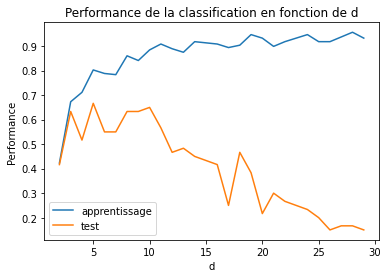

In [21]:
##trace courbes performances##
import matplotlib.pyplot as plt
x=[]#axe x/absisse
perfs_train=[]#axe y/perf apprentissage
perfs_test=[]#axe y/perf test
for i in range(2,30):
    x.append(i)
    #copie de la case precedente en modifiant discretisation
    d=i
    Xd = discretise(X, d)   # application de la discrétisation
    modelsA = []
    for cl in range(len(itrain)):
        modelsA.append(learnMarkovModel(Xd[itrain[cl]], d))
    proba_train=np.array([[probaSequence(Xd[i], modelsA[cl][0], modelsA[cl][1]) for i in ia]
                      for cl in range(len(itrain))])
    proba_test=np.array([[probaSequence(Xd[i], modelsA[cl][0], modelsA[cl][1]) for i in it]
                      for cl in range(len(itest))])
    inum_train = Ynum[ia]
    for num, char in enumerate((ia)):
        inum_train[itrain == char] = num
    inum_test = Ynum[it]
    for num, char in enumerate((it)):
        inum_test[itest == char] = num
    pred_train = proba_train.argmax(0)
    pred_test = proba_test.argmax(0)
    pourcent_train=np.where(pred_train != inum_train, 0.,1.).mean()
    pourcent_test=np.where(pred_test != inum_test, 0.,1.).mean()
    
    perfs_train.append(pourcent_train)
    perfs_test.append(pourcent_test)
    
#affichage du graph de performance
plt.plot(x,perfs_train)
plt.plot(x,perfs_test)
plt.xlabel('d')
plt.ylabel('Performance')
plt.legend(['apprentissage','test'])
plt.title('Performance de la classification en fonction de d')

plt.show()


#les résultats du train s'ameliorent mais les resultats du test s'empirent  avec l'augentation de la discrétisation
#C'est le phenomene de sur-apprentissage: quand d augmente on manque d'exemples
#pour bien estimer les paramtres initiales Pi et la matrice de transition A.

#Sur le graphique on retrouve les resultats pour le test et le train pour d=20.


### C2. Lutter contre le sur-apprentissage
Cette base de données met en lumière le phénomène de sur-apprentissage : il y a peu de données et dès que le nombre d'états augmente, il y a trop peu d'exemple pour estimer correctement les matrices {$A, \pi$}. De nombreuses cases sont donc à 0, voire des lignes entières (d'où la sécurisation du code pour la normalisation des matrices stochastiques).

Ces 0 sont particulièrement discriminants: considérant la classe {$c$}, ils permettent d'éliminer de cette classe tout signal présentant cette caractéristique. Cette règle est trop forte compte tenu de la taille de la base d'apprentissage. Nous proposons une astuce pour palier cette faiblesse : lors du comptage, initialiser les matrices {$A, \pi$} avec ones au lieu de zeros . On fait semblant d'avoir observer une transition de chaque type avant même le début du comptage.

Comparer les performances en test.

In [22]:
def learnMarkovModelv2(Xc, d):
    A = np.ones((d, d))
    Pi = np.ones(d)
    for j in range(len(Xc)):
        a = Xc[j]
        etat0 = int(a[0])
        Pi[etat0] += 1
        for x in range(len(a)-1): #on parcourt les données de chaque ex de la lettre
            a_i = int(a[x])
            a_j = int(a[x + 1])
            A[a_i][a_j] += 1
    A = A / np.maximum(A.sum(1).reshape(d, 1), 1) #normalisation
    Pi = Pi / Pi.sum()
    
    return Pi, A

In [23]:
##Apprentissage avec itrain##

d = 20
Xd = discretise(X, d)   # application de la discrétisation
modelsA2 = []
for i in range(len(itrain)): # parcours de toutes les classes et optimisation des modèles
    modelsA2.append(learnMarkovModelv2(Xd[itrain[i]], d))    

##probas##
proba_train2=np.array([[probaSequence(Xd[i], modelsA2[j][0], modelsA2[j][1]) for i in ia]
                  for j in range(len(itrain))])

proba_test2=np.array([[probaSequence(Xd[i], modelsA2[j][0], modelsA2[j][1]) for i in it]
                  for j in range(len(itest))])

##Evalutation##
inum_train2 =Ynum[ia]

for num, char in enumerate((ia)):
    inum_train2[itrain == char] = num

inum_test2 = Ynum[it]
for num, char in enumerate((it)):
    inum_test2[itest == char] = num

# Calcul de la classe la plus probable :
pred_train2 = proba_train2.argmax(0) # max colonne par colonne
pred_test2 = proba_test2.argmax(0) # max colonne par colonne

# Calcul d'un pourcentage de bonne classification :
pourcent_train2=np.where(pred_train2 != inum_train2, 0.,1.).mean()
pourcent_test2=np.where(pred_test2 != inum_test2, 0.,1.).mean()
print("pourcent train2 (avec d=",d,")=",pourcent_train2)
print("pourcent test2 (avec d=",d,")=",pourcent_test2)

pourcent train2 (avec d= 20 )= 0.8365384615384616
pourcent test2 (avec d= 20 )= 0.65


## D. Evaluation qualitative

Nous nous demandons maintenant où se trouvent les erreurs que nous avons commises...

Calcul de la matrice de confusion: pour chaque échantillon de test, nous avons une prédiction (issue du modèle) et une vérité terrain (la vraie étiquette). En posant Nc le nombre de classes, la matrice de confusion est une matrice (Nc x Nc) où nous comptons le nombre d'échantillon de test dans chaque catégorie :

- Initialisation à 0 : 

In [24]:
conf = np.zeros((26,26))

- Pour chaque échantillon, incrément de la case (prediction, vérité)

In [25]:
probas=np.array([[probaSequence(Xd[i], modelsA2[j][0], modelsA2[j][1]) for i in range(len(X))]
                  for j in range(len(itrain))])
classes_predites=probas.argmax(0) #affichage des classes predites par le model 
#print(classes_predites)

In [26]:
#transformation des lettres de Y en nombre pour comparaison avec predictions
def f(c):
    return ord(c) - ord('a')

In [27]:
classes=[]
for lettre in Y:
    classes.append(f(lettre))
#incrementations
for i in range(len(classes_predites)):
    conf[classes[i]][classes_predites[i]]+=1

#print(classes)

- Tracé de la matrice : 

Text(0, 0.5, 'Prédiction')

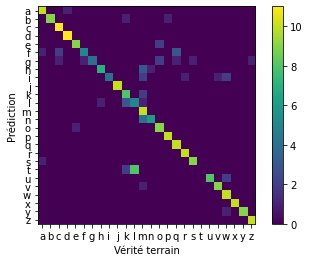

In [28]:
plt.figure()
plt.imshow(conf, interpolation = 'nearest')
plt.colorbar()
plt.xticks(np.arange(26), np.unique(Y))
plt.yticks(np.arange(26), np.unique(Y))
plt.xlabel(u'Vérité terrain')
plt.ylabel(u'Prédiction')
#plt.savefig("mat_conf_lettres.png")

## E. Modèle génératif

Utiliser les modèles appris pour générer de nouvelles lettres manuscrites.

### E1. Tirage selon une loi de probabilité discrète

- faire la somme cumulée de la loi {$sc$}
- tirer un nombre aléatoire {$t$} entre 0 et 1
- trouver la première valeur de {$sc$} qui est supérieure à {$t$}
- retourner cet état 

**Note :** comme vu en cours, tout repose sur la somme cumulée (notée ici `sc$`, calculable en appelant `np.cumsum`. Sur un exemple: la loi `V = [0.2, 0.4, 0.3, 0.1]` a pour somme cumulée `V.cumsum() == [0.2,  0.6,  0.9,  1.0]`

### E2. Génération d'une séquence de longueur N

- tirer un état {$s_0$} selon Pi
- tant que la longueur n'est pas atteinte :
  - tirer un état {$s_{t+1}$} selon {$A[s_{t}]$} 

In [29]:
def generate(Pi,A,N):
    sequence = []
    
    # Tirage premier angle
    Pi1=Pi.cumsum()
    t1=random.random()
    sequence.append(np.where(Pi1>=t1)[0][0])
    
    # Tirage des autres angles
    for i in range(1, N):
        prev_angle = sequence[i-1]
        for j in range(A.shape[0]):
            A2 = A[prev_angle].cumsum()
            t2 = random.random()
            if t2<A2[j]:
                sequence.append(j)
                break

    return np.array(sequence) 

### E3. Affichage du résultat

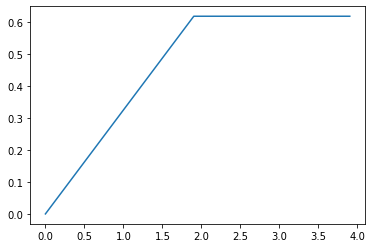

In [47]:
d=20
n_angle=4
n_lettre=1
letter="z"
letter_int=ord(letter)

for i in range(n_lettre):
    newa = generate(models[letter_int][0], models[letter_int][1], n_angle)   # generation d'une séquence d'états
    intervalle = 360. / d                                                    # pour passer des états => valeur d'angles
    newa_continu = np.array([i * intervalle for i in newa])                  # conv int => double
    tracerLettre(newa_continu)

# Exercice supplémentaire : Modèle MLP pour classification de lettre

In [31]:
with open('ressources/lettres.pkl', 'rb') as f:
    data = pkl.load(f, encoding='latin1') 
X = np.array(data.get('letters')) # récupération des données sur les lettres
Y = np.array(data.get('labels')) # récupération des étiquettes associées

<ipython-input-31-424f0140d231>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  X = np.array(data.get('letters')) # récupération des données sur les lettres


In [32]:
print("X[0]:\n",X[0])

# On a pas le meme nombre de degres par exemple, il faut faire du zero padding
# Normalement le reseau de neurone saura ignorer les 0 à la fin grâce a l'apprentissage
deg_max = -np.inf
for ex in X:
    if ex.size > deg_max:
        deg_max = ex.size
print("deg_max:",deg_max)
X_train = np.zeros((X.size, deg_max))
print(X_train.shape)
print(X.size)
for i, ex in enumerate(X):
    if ex.size == deg_max:
        X_train[i] = ex
    else:
        for j, deg in enumerate(ex):
            X_train[i][j] = deg
print("X_pad:\n",X_train[0])

X[0]:
 [ 36.214493 347.719116 322.088898 312.230957 314.851013 315.487213
 313.556702 326.534973 141.288971 167.606689 199.321594 217.911087
 226.443298 235.002472 252.354492 270.045654 291.665161 350.934723
  17.892815  20.281025  28.207161  43.883423  53.459026]
deg_max: 46
(268, 46)
268
X_pad:
 [ 36.214493 347.719116 322.088898 312.230957 314.851013 315.487213
 313.556702 326.534973 141.288971 167.606689 199.321594 217.911087
 226.443298 235.002472 252.354492 270.045654 291.665161 350.934723
  17.892815  20.281025  28.207161  43.883423  53.459026   0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.      ]


In [33]:
# On doit normaliser les valeurs d'angles
# On devrait peut etre utiliser les radians ou normaliser en utilisant la trigonometrie
# On peut aussi discretiser les valeurs comme pour markov ?

for i, ex in enumerate(X_train):
    X_train[i] = ex/np.sum(X_train[i].max())
print(X_train[0])

# for i, ex in enumerate(X_train):
#     X_train[i] = ex/360.
# print(X_train[0])

[0.10319439 0.99083702 0.91780288 0.88971235 0.89717829 0.89899116
 0.8934901  0.93047211 0.40260756 0.47760076 0.56797342 0.62094479
 0.6452576  0.66964725 0.7190924  0.76950395 0.83110944 1.
 0.05098616 0.05779145 0.08037723 0.12504725 0.15233325 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [34]:
print("Y:\n",Y)
n_class = len(np.unique(Y))
print("n_class:",n_class)

def one_hot_encoding(char):
    Y_one_hot = np.zeros((n_class))
    Y_one_hot[ord(char)-97] = 1
    return Y_one_hot

Y_one_hot = [one_hot_encoding(Y[i]) for i in range(len(Y))]
print("Y[0]:",Y[12])
print("Y_one_hot[0]:\n",Y_one_hot[12])

Y:
 ['a' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'b' 'b'
 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'c' 'd' 'd' 'd'
 'd' 'd' 'd' 'd' 'd' 'd' 'd' 'd' 'e' 'e' 'e' 'e' 'e' 'e' 'e' 'e' 'e' 'e'
 'e' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'f' 'g' 'g' 'g' 'g' 'g' 'g'
 'g' 'g' 'g' 'g' 'g' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'h' 'i' 'i'
 'i' 'i' 'i' 'i' 'i' 'i' 'i' 'i' 'j' 'j' 'j' 'j' 'j' 'j' 'j' 'j' 'j' 'j'
 'k' 'k' 'k' 'k' 'k' 'k' 'k' 'k' 'k' 'k' 'l' 'l' 'l' 'l' 'l' 'l' 'l' 'l'
 'l' 'l' 'm' 'm' 'm' 'm' 'm' 'm' 'm' 'm' 'm' 'm' 'n' 'n' 'n' 'n' 'n' 'n'
 'n' 'n' 'n' 'n' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'o' 'p' 'p' 'p' 'p'
 'p' 'p' 'p' 'p' 'p' 'p' 'q' 'q' 'q' 'q' 'q' 'q' 'q' 'q' 'q' 'q' 'r' 'r'
 'r' 'r' 'r' 'r' 'r' 'r' 'r' 'r' 's' 's' 's' 's' 's' 's' 's' 's' 's' 's'
 't' 't' 't' 't' 't' 't' 't' 't' 't' 't' 'u' 'u' 'u' 'u' 'u' 'u' 'u' 'u'
 'u' 'u' 'v' 'v' 'v' 'v' 'v' 'v' 'v' 'v' 'v' 'v' 'w' 'w' 'w' 'w' 'w' 'w'
 'w' 'w' 'w' 'w' 'x' 'x' 'x' 'x' 'x' 'x' 'x' 'x

In [35]:
# On check la repartition des classes pour voir si on a besoin de mettre un poids
_, counts = np.unique(Y, return_counts=True)
print(counts)
print(counts.std())
print(counts.mean())

[11 11 11 11 11 11 11 11 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10]
0.46153846153846156
10.307692307692308


In [36]:
percent_train = 0.8
X_train, X_test = X_train[:int(percent_train*X_train.shape[0])], X_train[int(percent_train*X_train.shape[0]):]
Y_train, Y_test = Y_one_hot[:int(percent_train*len(Y_one_hot))], Y_one_hot[int(percent_train*len(Y_one_hot)):]

Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(214, 46)
(54, 46)
(214, 26)
(54, 26)


In [37]:
import tensorflow as tf

def build_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(deg_max, input_shape=X_train.shape, activation="linear"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(n_class, activation="softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [38]:
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 214, 46)           2162      
_________________________________________________________________
dense_1 (Dense)              (None, 214, 32)           1504      
_________________________________________________________________
dense_2 (Dense)              (None, 214, 26)           858       
Total params: 4,524
Trainable params: 4,524
Non-trainable params: 0
_________________________________________________________________


In [39]:
history = model.fit(X_train, Y_train,
                    epochs=50,
                    validation_data=(X_test, Y_test),
                    )

Epoch 1/50
7/7 [==============================] - 1s 105ms/step - loss: 3.2774 - accuracy: 0.0591 - val_loss: 3.3647 - val_accuracy: 0.0185
Epoch 2/50
7/7 [==============================] - 0s 5ms/step - loss: 3.1635 - accuracy: 0.0891 - val_loss: 3.4511 - val_accuracy: 0.0000e+00
Epoch 3/50
7/7 [==============================] - 0s 5ms/step - loss: 3.0648 - accuracy: 0.0919 - val_loss: 3.5558 - val_accuracy: 0.0000e+00
Epoch 4/50
7/7 [==============================] - 0s 5ms/step - loss: 2.9767 - accuracy: 0.1062 - val_loss: 3.6765 - val_accuracy: 0.0000e+00
Epoch 5/50
7/7 [==============================] - 0s 5ms/step - loss: 2.8772 - accuracy: 0.1553 - val_loss: 3.8077 - val_accuracy: 0.0000e+00
Epoch 6/50
7/7 [==============================] - 0s 5ms/step - loss: 2.7613 - accuracy: 0.2421 - val_loss: 3.9523 - val_accuracy: 0.0000e+00
Epoch 7/50
7/7 [==============================] - 0s 5ms/step - loss: 2.6692 - accuracy: 0.2309 - val_loss: 4.1067 - val_accuracy: 0.0000e+00
Epoch 8/

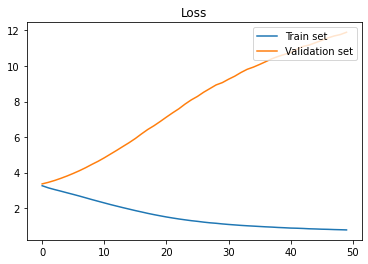

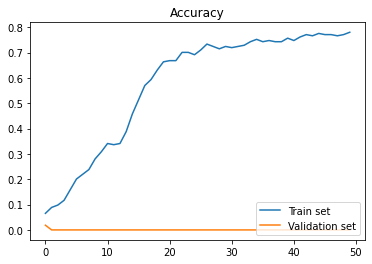

In [40]:
#Train set data
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

#Validation set data
val_loss_curve = history.history["val_loss"]
val_acc_curve = history.history["val_accuracy"]

#Loss plot
plt.plot(loss_curve, label="Train set")
plt.plot(val_loss_curve, label="Validation set")
plt.legend(loc='upper right')
plt.title("Loss")
plt.show()

#Accuracy plot
plt.plot(acc_curve, label="Train set")
plt.plot(val_acc_curve, label="Validation set")
plt.legend(loc='lower right')
plt.title("Accuracy")
plt.show()

In [41]:
# Premier model ne fonctionne pas, peut être un probleme de normalisation
# Après avoir enlever la normalisation, pas beaucoup de changement
# On overfit peut etre car le model est trop grand et qu'il y a peu de donnees
# Apres diminution du nombre de parametre dans le model, on est toujours en overfitting complet
# Peut etre un probleme de repartition des classes mais après test, les classes de Y sont bien repartis
# Conclusion : probablement pas assez de données pour un modèle MLP

In [42]:
# On va tester si on a assez de données en ajoutant des données grâce au modele génératif 
# programmé precedemment. Cela va nous permettre de conclure si il y avait pas assez de donnée
# ou si l'erreur provient d'autre part.

# Exercice supplémentaire : Fusion de modele Markov + MLP